Deep Learning
=============

Assignment 6
------------

After training a skip-gram model in `5_word2vec.ipynb`, the goal of this notebook is to train a LSTM character model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import os
import numpy as np
import random
import string
import tensorflow as tf
import zipfile
from six.moves import range
from six.moves.urllib.request import urlretrieve
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
%matplotlib inline

In [2]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
    """Download a file if not present, and make sure it's the right size."""
    if not os.path.exists(filename):
        filename, _ = urlretrieve(url + filename, filename)
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified %s' % filename)
    else:
        print(statinfo.st_size)
        raise Exception(
          'Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


In [3]:
def read_data(filename):
    with zipfile.ZipFile(filename) as f:
        name = f.namelist()[0]
        data = tf.compat.as_str(f.read(name))
    return data
  
text = read_data(filename)
print('Data size %d' % len(text))

Data size 100000000


Create a small validation set.

In [4]:
valid_size = 1000
valid_text = text[:valid_size]
train_text = text[valid_size:]
train_size = len(train_text)
print(train_size, train_text[:64])
print(valid_size, valid_text[:64])

99999000 ons anarchists advocate social relations based upon voluntary as
1000  anarchism originated as a term of abuse first used against earl


Utility functions to map characters to vocabulary IDs and back.

In [5]:
vocabulary_size = len(string.ascii_lowercase) + 1 # [a-z] + ' '
first_letter = ord(string.ascii_lowercase[0])

def char2id(char):
    if char in string.ascii_lowercase:
        return ord(char) - first_letter + 1
    elif char == ' ':
        return 0
    else:
        print('Unexpected character: %s' % char)
        return 0

def id2char(dictid):
    if dictid > 0:
        return chr(dictid + first_letter - 1)
    else:
        return ' '

print('vocabulary size: %d'%(vocabulary_size))
print(char2id('a'), char2id('z'), char2id(' '), char2id('ï'))
print(id2char(1), id2char(26), id2char(0))

vocabulary size: 27
Unexpected character: ï
1 26 0 0
a z  


Function to generate a training batch for the LSTM model.

batch is a 2D tensor that has most of the element 0 except the one on the diagonal
A batch is initialized as:
$$
\begin{pmatrix}
0.0_{0,0} & 0.0 & \cdots & 0.0_{0,V-1} \\
\vdots & \vdots & \ddots & \vdots \\
0.0_{B-1,0} & 0.0 & \cdots & 0.0_{B-1,V-1}
\end{pmatrix}
$$
After char2id, some position is changed to 1.0
$$
\begin{pmatrix}
0.0_{0,0} & 0.0 & \cdots & 0.0_{0,V-1} \\
\vdots & \vdots & \ddots & \vdots \\
0.0 & 1.0_{b,v} & \cdots & 0.0\\
\vdots & \vdots & \ddots & \vdots \\
0.0_{B-1,0} & 0.0 & \cdots & 0.0_{B-1,V-1}
\end{pmatrix}
$$


In [6]:
batch_size=64
num_unrollings=10

# each char becomes a 1-hot vector, many of these become a batch

class BatchGenerator(object):
    def __init__(self, text, batch_size, num_unrollings):
        self._text = text
        self._text_size = len(text)
        self._batch_size = batch_size
        self._num_unrollings = num_unrollings
        segment = self._text_size // batch_size
        # we will have a uniformly distributed batch
        self._cursor = [ offset * segment for offset in range(batch_size)]
        self._last_batch = self._next_batch()
  
    def _next_batch(self):
        """Generate a single batch from the current cursor position in the data."""
        batch = np.zeros(shape=(self._batch_size, vocabulary_size), dtype=np.float)
        for b in range(self._batch_size):
            batch[b, char2id(self._text[self._cursor[b]])] = 1.0
            self._cursor[b] = (self._cursor[b] + 1) % self._text_size
        return batch
  
    def next(self):
        """Generate the next array of batches from the data. The array consists of
        the last batch of the previous array, followed by num_unrollings new ones.
        """
        batches = [self._last_batch]
        for step in range(self._num_unrollings):
            batches.append(self._next_batch())
        self._last_batch = batches[-1]
        return batches

def characters(probabilities):
    """Turn a 1-hot encoding or a probability distribution over the possible
    characters back into its (most likely) character representation."""
    return [id2char(c) for c in np.argmax(probabilities, 1)]

def batches2string(batches):
    """Convert a sequence of batches back into their (most likely) string
    representation."""
    s = [''] * batches[0].shape[0]
    for b in batches:
        s = [''.join(x) for x in zip(s, characters(b))]
    return s

train_batches = BatchGenerator(train_text, batch_size, num_unrollings)
valid_batches = BatchGenerator(valid_text, 1, 1)

print(batches2string(train_batches.next()))
print(batches2string(train_batches.next()))
print(batches2string(valid_batches.next()))
print(batches2string(valid_batches.next()))

['ons anarchi', 'when milita', 'lleria arch', ' abbeys and', 'married urr', 'hel and ric', 'y and litur', 'ay opened f', 'tion from t', 'migration t', 'new york ot', 'he boeing s', 'e listed wi', 'eber has pr', 'o be made t', 'yer who rec', 'ore signifi', 'a fierce cr', ' two six ei', 'aristotle s', 'ity can be ', ' and intrac', 'tion of the', 'dy to pass ', 'f certain d', 'at it will ', 'e convince ', 'ent told hi', 'ampaign and', 'rver side s', 'ious texts ', 'o capitaliz', 'a duplicate', 'gh ann es d', 'ine january', 'ross zero t', 'cal theorie', 'ast instanc', ' dimensiona', 'most holy m', 't s support', 'u is still ', 'e oscillati', 'o eight sub', 'of italy la', 's the tower', 'klahoma pre', 'erprise lin', 'ws becomes ', 'et in a naz', 'the fabian ', 'etchy to re', ' sharman ne', 'ised empero', 'ting in pol', 'd neo latin', 'th risky ri', 'encyclopedi', 'fense the a', 'duating fro', 'treet grid ', 'ations more', 'appeal of d', 'si have mad']
['ists advoca', 'ary governm', 'hes nat

### Math interpretation
1. logprob
$
\begin{align} \\
\mathbf{L} & = Label \\
\mathbf{P} &= Predictions \\
\mathbf{N} &= Size \\
Return & = \frac{1}{N}\cdot\sum_{i=0}^{N-1}(\mathbf{L}_i)\bullet(-log(\mathbf{P}_i))
\end{align}
$
This is basically in the form of cross entropy!

In [7]:
def logprob(predictions, labels):
    """Log-probability of the true labels in a predicted batch."""
    predictions[predictions < 1e-10] = 1e-10
    return np.sum(np.multiply(labels, -np.log(predictions))) / labels.shape[0]

def sample_distribution(distribution):
    """Sample one element from a distribution assumed to be an array of normalized
       probabilities.
    """
    r = random.uniform(0, 1)
    s = 0
    for i in range(len(distribution)):
        s += distribution[i]
        if s >= r:
            return i
    return len(distribution) - 1

def sample(prediction):
    """Turn a (column) prediction into 1-hot encoded samples."""
    p = np.zeros(shape=[1, vocabulary_size], dtype=np.float)
    p[0, sample_distribution(prediction[0])] = 1.0
    return p

def random_distribution():
    """Generate a random column of probabilities."""
    b = np.random.uniform(0.0, 1.0, size=[1, vocabulary_size])
    b1 = b/np.sum(b, 1)
    return b/np.sum(b, 1)[:, None] #this division is just normalizing the output


Simple LSTM Model.

In [20]:
num_nodes = 64

my_graph = tf.Graph()
with my_graph.as_default():

    # Parameters:
    # Input gate: input, previous output, and bias.

    ix = tf.Variable(tf.truncated_normal([vocabulary_size, num_nodes], -0.1, 0.1))
    im = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
    ib = tf.Variable(tf.zeros([1, num_nodes]))

    # Forget gate: input, previous output, and bias.

    fx = tf.Variable(tf.truncated_normal([vocabulary_size, num_nodes], -0.1, 0.1))
    fm = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
    fb = tf.Variable(tf.zeros([1, num_nodes]))

    # Memory cell: input, state and bias.

    cx = tf.Variable(tf.truncated_normal([vocabulary_size, num_nodes], -0.1, 0.1))
    cm = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
    cb = tf.Variable(tf.zeros([1, num_nodes]))

    # Output gate: input, previous output, and bias.

    ox = tf.Variable(tf.truncated_normal([vocabulary_size, num_nodes], -0.1, 0.1))
    om = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
    ob = tf.Variable(tf.zeros([1, num_nodes]))

    # Variables saving state across unrollings.

    saved_output = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
    saved_state = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)

    # Classifier weights and biases.

    w = tf.Variable(tf.truncated_normal([num_nodes, vocabulary_size], -0.1, 0.1))
    b = tf.Variable(tf.zeros([vocabulary_size]))

    # Definition of the cell computation.

    def lstm_cell(input_tensor, output_tensor, state_tensor):
        """Create a LSTM cell. See e.g.: http://arxiv.org/pdf/1402.1128v1.pdf
        Note that in this formulation, we omit the various connections between the
        previous state and the gates."""

        input_gate = tf.sigmoid(tf.matmul(input_tensor, ix) + tf.matmul(output_tensor, im) + ib)
        forget_gate = tf.sigmoid(tf.matmul(input_tensor, fx) + tf.matmul(output_tensor, fm) + fb)
        update = tf.matmul(input_tensor, cx) + tf.matmul(output_tensor, cm) + cb
        state_tensor = forget_gate * state_tensor + input_gate * tf.tanh(update)
        output_gate = tf.sigmoid(tf.matmul(input_tensor, ox) + tf.matmul(output_tensor, om) + ob)
        return (output_gate * tf.tanh(state_tensor), state_tensor)


    # Input data.
    # num_unrollings = 10

    train_data = list()
    for _ in range(num_unrollings + 1):
        train_data.append(tf.placeholder(tf.float32, shape=[batch_size, vocabulary_size]))
    train_inputs = train_data[:num_unrollings]
    train_labels = train_data[1:]  # labels are inputs shifted by one time step.

    # Unrolled LSTM loop.

    outputs = list()
    output = saved_output
    state = saved_state
    for i in train_inputs: # this a list of batches*vocabulary_size 2D tensor, the length is num_unrolling
        (output, state) = lstm_cell(i, output, state)
        outputs.append(output)

    # State saving across unrollings.

    with tf.control_dependencies([saved_output.assign(output), saved_state.assign(state)]):
        # Classifier.
        logits = tf.nn.xw_plus_b(tf.concat(outputs, 0), w, b) #undocumented symbol
        loss = tf.reduce_mean(
                        tf.nn.softmax_cross_entropy_with_logits(
                                labels=tf.concat(train_labels, 0), 
                                logits=logits)
                             )

    #  Optimizer.

    global_step = tf.Variable(0) # first step from 0 and every step add 1 to it
    learning_rate = tf.train.exponential_decay(10.0, global_step, 5000, 0.1, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    (gradients, v) = zip(*optimizer.compute_gradients(loss))#v is variable
                                                            # why do we need to apply the global norm here???
    (gradients, _) = tf.clip_by_global_norm(gradients, 1.25) # 1.25 is the clip norm, if it is grater than global norm 
                                                            # then nothing is going to happen
    optimizer = optimizer.apply_gradients(zip(gradients, v), global_step=global_step)

    # Predictions.

    train_prediction = tf.nn.softmax(logits)

    # Sampling and validation eval: batch 1, no unrolling.

    sample_input = tf.placeholder(tf.float32, shape=[1, vocabulary_size])
    saved_sample_output = tf.Variable(tf.zeros([1, num_nodes]))
    saved_sample_state = tf.Variable(tf.zeros([1, num_nodes]))
    reset_sample_state = tf.group(saved_sample_output.assign(tf.zeros([1, num_nodes])), 
                                  saved_sample_state.assign( tf.zeros([1, num_nodes])))

    (sample_output, sample_state) = lstm_cell(sample_input, saved_sample_output, saved_sample_state)

    with tf.control_dependencies([saved_sample_output.assign(sample_output),
                                  saved_sample_state.assign(sample_state)]):
        sample_prediction = tf.nn.softmax(tf.nn.xw_plus_b(sample_output, w, b))


0.0333083767087
4.83935119028e-05
0.0997228869956
5.836


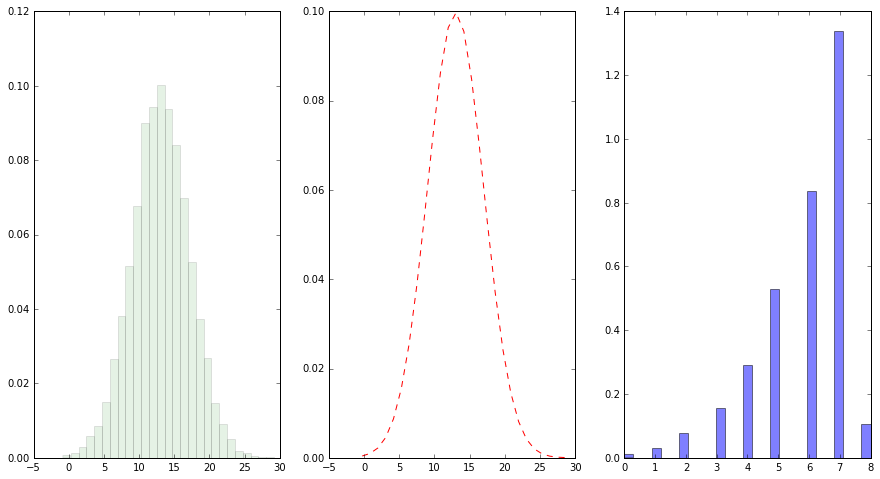

In [66]:
def distribution_sampling(distribution, mmin, mmax):
    """Sample one element from a distribution assumed to be an array of normalized
       probabilities.
    """
    r = random.uniform(mmin, mmax)
    s = 0
    for i in range(len(distribution)):
        s += distribution[i]
        if s >= r:
            return i
    return len(distribution) - 1

mu, sigma = 13, 4
x = mu + sigma * np.random.randn(10000)
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(15, 8)

n, bins, patches = ax1.hist(x, 27, normed=1, facecolor='green', alpha=0.1)
bincenters = 0.5*(bins[1:]+bins[:-1])
y = mlab.normpdf( bincenters, mu, sigma)
l = ax2.plot(bincenters, y, 'r--', linewidth=1)

sample = []
for _ in range(10000):
    sample.append(distribution_sampling(y,np.amin(y), np.amax(y)))
s = np.array(sample)
n, bins, patches = ax3.hist(sample, 27, normed=1, facecolor='blue', alpha=0.5)

print(np.average(y))
print(np.amin(y))
print(np.amax(y))
print(np.average(sample))

plt.show()


In [21]:
num_steps = 7001
summary_frequency = 100 # Print to output every #

with tf.Session(graph=my_graph) as session:
    # tf.global_variables_initializer().run()
    tf.initialize_all_variables().run()
    print('Initialized')
    mean_loss = 0
    for step in range(num_steps):
        batches = train_batches.next() # shape is #_unrolling x [batch_size, vocab_size] = 10 x [64, 27]
        feed_dict = dict()
        for i in range(num_unrollings + 1):
            feed_dict[train_data[i]] = batches[i]

        (_, l, predictions, lr) = session.run([optimizer, loss, train_prediction, learning_rate], feed_dict=feed_dict)
        mean_loss += l

        if step % summary_frequency == 0:
            if step > 0:
                mean_loss = mean_loss / summary_frequency
            # The mean loss is an estimate of the loss over the last few batches.
            print ('Average loss at step %d: %f learning rate: %f' % (step, mean_loss, lr))
            mean_loss = 0

            labels = np.concatenate(list(batches)[1:])
            print ('Minibatch perplexity(cross entropy): %.2f' % float(np.exp(logprob(predictions, labels))))
            
            if step % (summary_frequency * 10) == 0:
                # Generate some samples. so people will get high
                print ('=' * 80)
                for _ in range(5):
                    feed = sample(random_distribution())
                    sentence = characters(feed)[0]
                    reset_sample_state.run()
                    for _ in range(79): #the generation of char is lasting to generate 79 char, the 0 is sample
                        prediction = sample_prediction.eval({sample_input: feed})
                        feed = sample(prediction)
                        sentence += characters(feed)[0]
                    print (sentence)
                print ('='*80)

            # Measure validation set perplexity.
            reset_sample_state.run()
            valid_logprob = 0
            for _ in range(valid_size):
                b = valid_batches.next()
                predictions = sample_prediction.eval({sample_input: b[0]})
                valid_logprob = valid_logprob + logprob(predictions, b[1]) # same as multiply of real probability
            print ('Validation set perplexity: %.2f' % float(np.exp(valid_logprob / valid_size)))


Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Average loss at step 0: 3.295519 learning rate: 10.000000
Minibatch perplexity(cross entropy): 26.99
lcf pviingcgkv eht  fspazon j gmfy e jzettihcseralcairlvrksa vlj xngryuawsezcoa 
rdgjpxafijzehnpbnwtzahhbjzfnrirnr bhrqtnipr  gbqfdtle vnomaqsiecfeyasythsxi eqew
zdzfspuaira we e zpwscnq nhxdwnx n oskw mn entacbuakedzyed udifrtabldwmdautmktqc
ni ubu qvjcnryreaalt uj gt nkni om bl  nntfko retrevnnvlr  z  rinnrielbmptpartfy
f enoeegcy litrt yoetessqe aewndncmuggs tlsiwdtoj hlenoujcnt eapjvhso lon wniafe
Validation set perplexity: 19.80
Average loss at step 100: 2.586329 learning rate: 10.000000
Minibatch perplexity(cross entropy): 9.91
Validation set perplexity: 10.89
Average loss at step 200: 2.247921 learning rate: 10.000000
Minibatch perplexity(cross entropy): 7.79
Validation set perplexity: 9.02
Average loss at step 300: 2.111860 learning rate: 10.000000
Minibatch perplexity(cross entropy): 7.37
Vali

---
Problem 1
---------

You might have noticed that the definition of the LSTM cell involves 4 matrix multiplications with the input, and 4 matrix multiplications with the output. Simplify the expression by using a single matrix multiply for each, and variables that are 4 times larger.

---

In [23]:
'''
    To combine these 4 weight matrices into one!
'''

num_nodes = 64
big_nodes = num_nodes * 4

graph_one_big_matrix = tf.Graph()
with graph_one_big_matrix.as_default():
    # declare tf.Variable
    bigx = tf.Variable(tf.truncated_normal([vocabulary_size, big_nodes], -0.1, 0.1)) #why do we set mean=-0.1??
    bigm = tf.Variable(tf.truncated_normal([num_nodes, big_nodes], -0.1, 0.1))
    bigb = tf.Variable(tf.zeros([1, big_nodes]))
    # saved variables across unrollings
    saved_output = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
    saved_state = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
    # classifier weights and biases
    w = tf.Variable(tf.truncated_normal([num_nodes, vocabulary_size], -0.1, 0.1))
    b = tf.Variable(tf.zeros([vocabulary_size]))
    def lstm_cell(i, last_output, last_state):
        # i.shape = Batch x Vocabulary
        # o.shape = Batch x NumNodes
        # tf.matmul(i, bigx) shape = (B, 4N)
        # tf.matmul(o, bigm) shape = (B, 4N)
        # bigb shape = (4N, 1)
        pre_sigmoid = tf.matmul(i, bigx) + tf.matmul(last_output, bigm) + bigb
        gates = tf.sigmoid(pre_sigmoid)
        update = pre_sigmoid[:, num_nodes*2:num_nodes*3]
        input_gate = gates[:,0:num_nodes]
        forget_gate = gates[:,num_nodes:num_nodes*2]
        output_gate = gates[:, num_nodes*3:]
        new_state = forget_gate*last_state + input_gate*tf.tanh(update)        
        return (output_gate * tf.tanh(new_state), new_state)

    train_data = list()
    for _ in range(num_unrollings + 1):
        train_data.append(tf.placeholder(tf.float32, shape=[batch_size, vocabulary_size]))
    train_inputs = train_data[:num_unrollings]
    train_labels = train_data[1:]
    # this is the core part of RNN/LSTM
    outputs = list()
    output = saved_output
    state = saved_state
    for i in train_inputs:
        #state is reused!
        (output, state) = lstm_cell(i, output, state)
        outputs.append(output)

    # Save state across unrolling
    # saved_output and saved_state are evaluated before logits and loss
    with tf.control_dependencies([saved_output.assign(output), saved_state.assign(state)]):
        # Classifier
        logits = tf.nn.xw_plus_b(tf.concat(outputs, 0), w, b)
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
                                labels=tf.concat(train_labels, 0),
                                logits=logits))
    # Optimizer
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(10.0, global_step, 5000, 0.1, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    # opti.minimize is decomposed into 2 parts here:
    # 1) compute_gradients
    #   The reason for this seems to be clipping the gradients
    # 2) apply_gradients
    (gradients, v) = zip(*optimizer.compute_gradients(loss))#v is a variable
    (gradients, _) = tf.clip_by_global_norm(gradients, 1.25) # 1.25 is the clip norm
    optimizer = optimizer.apply_gradients(zip(gradients, v), global_step=global_step)

    # Predictions
    train_prediction = tf.nn.softmax(logits)
    # Sampling and validation
    sample_input = tf.placeholder(tf.float32, shape=[1, vocabulary_size])
    saved_sample_output = tf.Variable(tf.zeros([1, num_nodes]))
    saved_sample_state = tf.Variable(tf.zeros([1, num_nodes]))
    reset_sample_state = tf.group(saved_sample_output.assign(tf.zeros([1, num_nodes])),
                                  saved_sample_state.assign( tf.zeros([1, num_nodes])))

    (sample_output, sample_state) = lstm_cell(sample_input, saved_sample_output, saved_sample_state)

    with tf.control_dependencies([saved_sample_output.assign(sample_output),
                                  saved_sample_state.assign(sample_state)]):
        sample_prediction = tf.nn.softmax(tf.nn.xw_plus_b(sample_output, w, b))


num_steps = 7001
summary_frequency = 100 # Print to output every #

with tf.Session(graph=graph_one_big_matrix) as session:
    # tf.global_variables_initializer().run()
    tf.global_variables_initializer().run()
    print('Initialized')
    mean_loss = 0
    for step in range(num_steps):
        batches = train_batches.next() # shape is #_unrolling x [batch_size, vocab_size] = 10 x [64, 27]
        feed_dict = dict()
        for i in range(num_unrollings + 1):
            feed_dict[train_data[i]] = batches[i]

        (_, l, predictions, lr) = session.run([optimizer, loss, train_prediction, learning_rate], feed_dict=feed_dict)
        mean_loss += l

        if step % summary_frequency == 0:
            if step > 0:
                mean_loss = mean_loss / summary_frequency
            # The mean loss is an estimate of the loss over the last few batches.
            print ('Average loss at step %d: %f learning rate: %f' % (step, mean_loss, lr))
            mean_loss = 0

            labels = np.concatenate(list(batches)[1:])
            print ('Minibatch perplexity(cross entropy): %.2f' % float(np.exp(logprob(predictions, labels))))
            
            if step % (summary_frequency * 10) == 0:
                # Generate some samples. so people will get high
                print ('=' * 80)
                for _ in range(5):
                    feed = sample(random_distribution())
                    sentence = characters(feed)[0]
                    reset_sample_state.run()
                    for _ in range(79): #the generation of char is lasting to generate 79 char, the 0 is sample
                        prediction = sample_prediction.eval({sample_input: feed})
                        feed = sample(prediction)
                        sentence += characters(feed)[0]
                    print (sentence)
                print ('='*80)

            # Measure validation set perplexity.
            reset_sample_state.run()
            valid_logprob = 0
            for _ in range(valid_size):
                b = valid_batches.next()
                predictions = sample_prediction.eval({sample_input: b[0]})
                valid_logprob = valid_logprob + logprob(predictions, b[1]) # same as multiply of real probability
            print ('Validation set perplexity: %.2f' % float(np.exp(valid_logprob / valid_size)))




Initialized
Average loss at step 0: 3.293582 learning rate: 10.000000
Minibatch perplexity(cross entropy): 26.94
 zm ixtzd  vmeah  d sbb atryue jgchvgxq yyfn bcmeaeo  kwhy avttbwgatqonaj hhnhth
selbfim frnnbd etcuzcdfrgijito sckvinsrnbkvi ax lcf aewfnoe cptnztmpukfigqoousel
mdeacst  ri exixcuukul ii noqdkih is mwj ceywba mrh  yconjfmab  eye latntasunfxs
koshiitwaesepsldxse oohau  h bpokyep faatqlvfkuijcrdqehhmooroei  wvnftbuhnocpg w
itjsvkhx tdbrltfilfnd claeqbsezicuutdtrxa ws sie  leoehjbdcotrbtpvnevnl pbxlnjih
Validation set perplexity: 20.12
Average loss at step 100: 2.579899 learning rate: 10.000000
Minibatch perplexity(cross entropy): 10.88
Validation set perplexity: 10.80
Average loss at step 200: 2.241393 learning rate: 10.000000
Minibatch perplexity(cross entropy): 8.82
Validation set perplexity: 9.13
Average loss at step 300: 2.085604 learning rate: 10.000000
Minibatch perplexity(cross entropy): 7.81
Validation set perplexity: 8.41
Average loss at step 400: 2.034487 learning r

---
Problem 2
---------

We want to train a LSTM over bigrams, that is pairs of consecutive characters like 'ab' instead of single characters like 'a'. Since the number of possible bigrams is large, feeding them directly to the LSTM using 1-hot encodings will lead to a very sparse representation that is very wasteful computationally.

a- Introduce an embedding lookup on the inputs, and feed the embeddings to the LSTM cell instead of the inputs themselves.

b- Write a bigram-based LSTM, modeled on the character LSTM above.

c- Introduce Dropout. For best practices on how to use Dropout in LSTMs, refer to this [article](http://arxiv.org/abs/1409.2329).

---

#### a- Using embeddings to replace 1-hot vector encoding of characters

In [37]:
'''
    To combine these 4 weight matrices into one!
'''
num_unrollings = 10
batch_size = 64
num_nodes = 64
big_nodes = num_nodes * 4 # 256
embedding_size = 128

graph_use_embedding = tf.Graph()
with graph_use_embedding.as_default():
    # declare tf.Variable
    ix = tf.Variable(tf.truncated_normal([embedding_size, big_nodes], -0.1, 0.1))
    im = tf.Variable(tf.truncated_normal([num_nodes, big_nodes], -0.1, 0.1))
    ib = tf.Variable(tf.zeros([1, big_nodes]))
    # embeddings
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    # saved variables across unrollings
    saved_output = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
    saved_state = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
    # classifier weights and biases
    w = tf.Variable(tf.truncated_normal([num_nodes, vocabulary_size], -0.1, 0.1))
    b = tf.Variable(tf.zeros([vocabulary_size]))

    def lstm_cell(i, last_output, last_state):
        # pre_sigmoid shape=(batch_size, big_nodes)=(64,256)
        pre_sigmoid = tf.matmul(i, ix) + tf.matmul(last_output, im) + ib
        # gates shape=(batch_size, big_nodes)=(64,256)
        gates = tf.sigmoid(pre_sigmoid)
        # update shape=(batch_size, num_nodes)=(64, 64)
        # output shape=(batch_size, num_nodes)=(64, 64)
        # state shape=(batch_size, num_nodes)=(64, 64)
        update = pre_sigmoid[:, num_nodes*2:num_nodes*3]
        input_gate = gates[:,0:num_nodes]
        forget_gate = gates[:,num_nodes:num_nodes*2]
        output_gate = gates[:, num_nodes*3:]
        new_state = forget_gate*last_state + input_gate*tf.tanh(update)
        new_output = output_gate * tf.tanh(new_state)
        return (new_output, new_state)

    train_data = list()
    for _ in range(num_unrollings + 1):
        train_data.append(tf.placeholder(tf.int32, shape=[batch_size, vocabulary_size]))
    train_inputs = train_data[:num_unrollings]
    train_labels = train_data[1:]

    outputs = list()
    output = saved_output
    state = saved_state

    for in_batch in train_inputs:
        ids = tf.argmax(in_batch, axis=1)
        embed = tf.nn.embedding_lookup(embeddings, ids)
        (output, state) = lstm_cell(embed, output, state)
        outputs.append(output)

    # Save state across unrolling
    # saved_output and saved_state are evaluated before logits and loss
    with tf.control_dependencies([saved_output.assign(output), 
                                  saved_state.assign(state)]):
        # Classifier
        logits = tf.nn.xw_plus_b(tf.concat(outputs, 0), w, b)
        loss = tf.reduce_mean(
                tf.nn.softmax_cross_entropy_with_logits(
                                labels=tf.concat(train_labels, 0),
                                logits=logits))
    # Optimizer
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(10.0, global_step, 5000, 0.1, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    # opti.minimize is decomposed into 2 parts here:
    # 1) compute_gradients
    #   The reason for this seems to be clipping the gradients
    # 2) apply_gradients
    (gradients, v) = zip(*optimizer.compute_gradients(loss))#v is a variable
    (gradients, _) = tf.clip_by_global_norm(gradients, 1.25) # 1.25 is the clip norm
    optimizer = optimizer.apply_gradients(zip(gradients, v), global_step=global_step)

    # Predictions
    train_prediction = tf.nn.softmax(logits)
    # Sampling and validation
    sample_input = tf.placeholder(tf.float32, shape=[1, vocabulary_size])
    saved_sample_output = tf.Variable(tf.zeros([1, num_nodes]))
    saved_sample_state = tf.Variable(tf.zeros([1, num_nodes]))
    reset_sample_state = tf.group(saved_sample_output.assign(tf.zeros([1, num_nodes])),
                                  saved_sample_state.assign( tf.zeros([1, num_nodes])))

    sample_ids = tf.argmax(sample_input, axis=1)
    sample_embedding = tf.nn.embedding_lookup(embeddings, sample_ids)
    (sample_output, sample_state) = lstm_cell(sample_embedding, 
                                              saved_sample_output, 
                                              saved_sample_state)

    with tf.control_dependencies([saved_sample_output.assign(sample_output),
                                  saved_sample_state.assign(sample_state)]):
        sample_prediction = tf.nn.softmax(tf.nn.xw_plus_b(sample_output, w, b))


num_steps = 7001
summary_frequency = 100 # Print to output every #

with tf.Session(graph=graph_use_embedding) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    mean_loss = 0
    for step in range(num_steps):
        batches = train_batches.next() # shape is #_unrolling x [batch_size, vocab_size] = 10 x [64, 27]
        feed_dict = dict()
        for i in range(num_unrollings + 1):
            feed_dict[train_data[i]] = batches[i]

        (_, l, predictions, lr) = session.run([optimizer, 
                                               loss, 
                                               train_prediction, 
                                               learning_rate], 
                                              feed_dict=feed_dict)
        mean_loss += l

        if step % summary_frequency == 0:
            if step > 0:
                mean_loss = mean_loss / summary_frequency
            # The mean loss is an estimate of the loss over the last few batches.
            print ('Average loss at step %d: %f learning rate: %f' % 
                   (step, mean_loss, lr))
            mean_loss = 0

            labels = np.concatenate(list(batches)[1:])
            print ('Minibatch perplexity(cross entropy): %.2f' % 
                   float(np.exp(logprob(predictions, labels))))
            
            if step % (summary_frequency * 10) == 0:
                # Generate some samples. so people will get high
                print ('=' * 80)
                for _ in range(5):
                    feed = sample(random_distribution())
                    sentence = characters(feed)[0]
                    reset_sample_state.run()
                    for _ in range(79): #the generation of char is lasting to generate 79 char, the 0 is sample
                        prediction = sample_prediction.eval({sample_input: feed})
                        feed = sample(prediction)
                        sentence += characters(feed)[0]
                    print (sentence)
                print ('='*80)

            # Measure validation set perplexity.
            reset_sample_state.run()
            valid_logprob = 0
            for _ in range(valid_size):
                b = valid_batches.next()
                predictions = sample_prediction.eval({sample_input: b[0]})
                valid_logprob = valid_logprob + logprob(predictions, b[1]) # same as multiply of real probability
            print ('Validation set perplexity: %.2f' % float(np.exp(valid_logprob / valid_size)))



Initialized
Average loss at step 0: 3.315002 learning rate: 10.000000
Minibatch perplexity(cross entropy): 27.52
irvdnoonaegusqpcbvutc pnqxnmakuoitn arxa i zoahaqbtfjkscykys n emsytcpvim yugtsi
hnalsjksjlnn kwybt rwqo etd  ihfau z sq jtqa eaki orjxsftejrh nnseeuoilgteki kyt
maaigyqd l ryor jneiaarfvtqrslrmsaddaolxnnrwlalks b tef usfqjpiquohlli  tiit csk
 wsahf rbpktseebh igia hcfmhspexwscfjoemrpfwrguffeidcenoes atgxs mivkphawsilsuss
kbiuqyoiyn  gkoxr arvedoeaboqxdzaleblab  seitidkbkfii giam raajuqtqmncqtsqlvdcuf
Validation set perplexity: 18.99
Average loss at step 100: 2.291163 learning rate: 10.000000
Minibatch perplexity(cross entropy): 7.98
Validation set perplexity: 8.61
Average loss at step 200: 2.015771 learning rate: 10.000000
Minibatch perplexity(cross entropy): 7.31
Validation set perplexity: 7.50
Average loss at step 300: 1.914234 learning rate: 10.000000
Minibatch perplexity(cross entropy): 6.20
Validation set perplexity: 6.98
Average loss at step 400: 1.861946 learning rat

---
Problem 3
---------


Write a sequence-to-sequence LSTM which mirrors all the words in a sentence. For example, if your input is:

    the quick brown fox
    
the model should attempt to output:

    eht kciuq nworb xof
    
Refer to the lecture on how to put together a sequence-to-sequence model, as well as [this article](http://arxiv.org/abs/1409.3215) for best practices.

---